In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install optuna
!pip install dm-haiku
!pip install tensorflow-probability==0.17

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 12.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=91e186b43739d9ed07c6336d0041933c19eca32ac1dcca375b2cd4de5611ad2f
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

else:
    %cd /home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
from jax import random
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
from bnn_models import *
from train_utils import *
from data_utils import *
from hpo_util import *
from exp_utils import *
plt.style.use('ggplot')
%load_ext autoreload

/home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


In [2]:
if SERVER:
    data_dir = "/home/abdu/bio_ai/moses-incons-pen-xp/data"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [39]:
N = 600
P = 500

def func_v1(key, x):
    _, subkey = random.split(key, 2)
    noise = random.normal(subkey, shape=(N,))
    t1 = jnp.max(x[:,[0, 1]], axis=1)
    t2 = jnp.max(x[:,[2, 3, 4]], axis=1)
    y = (((10*jnp.sin(t1) + (t2**3)) / (1 + (x[:,0] + x[:,4])**2)) +
         jnp.sin(0.5*x[:,2])*(1 + jnp.exp(x[:,3] - 0.5*x[:,2])) + x[:,2]**2 + 2*jnp.sin(x[:,3]) + 2*x[:,4]) + noise

    return y

def generate_dataset_v1(seed):
    rng_key = random.PRNGKey(seed)
    key1, key2 = random.split(rng_key, 2)
    e = random.normal(key1, shape=(N,))
    z = random.normal(key2, shape=(N, P))
    dataset = jax.vmap(lambda a, b: 0.5*(a + b), in_axes=(None, 1), out_axes=1)(e, z)
    # dataset = 0.5*(e + z)
    output = func_v1(key1, dataset)

    return dataset, output

In [108]:
%autoreload
seed = 220
dataset, output = generate_dataset_v1(seed)
X_train_outer, X_train, X_val, X_test, \
y_train_outer, y_train, y_val, y_test, (train_indices, val_indices) = preprocess_data(seed, pd.DataFrame(dataset), pd.Series(output),
                                                           val_size=0.2, test_size=0.2, reset_index=True)

In [164]:
J_zeros = np.zeros((P, P))

In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from tree_utils import tree_stack

def false_selection_rate(ft_idxs):
    causal_fts = {0, 1, 2, 3, 4}
    sel_fts = set(ft_idxs)
    diff = sel_fts.difference(causal_fts)

    return (len(diff)/len(ft_idxs))

def negative_selection_rate(ft_idxs):
    causal_fts = {0, 1, 2, 3, 4}
    sel_fts = set(ft_idxs)
    diff = causal_fts.difference(sel_fts)

    return (len(diff)/len(causal_fts))

In [268]:
%autoreload
lr_0, disc_lr_0 = 1e-3, 0.5
temp = 1.0
epochs, num_cycles = 200, 20
eta, mu = 1.0, 100.0
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=32, shuffle=True)
bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                            0.25, 3, lr_0, disc_lr_0, [6], temp, 1.0,
                                                            eta, mu, J_zeros, "relu")

bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bnn_model, X_test, y_test, bnn_states, bnn_disc_states)
print(f"Test RMSE: {bnn_rmse_test}, r2_score: {bnn_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.17it/s]


Test RMSE: 2.510540008544922, r2_score: 0.7551984421164948


In [77]:
rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
rf_rmse, rf_r2 = eval_rf_model(rf_model, X_test, y_test)
print(f"Test RMSE: {rf_rmse}, r2_score: {rf_r2}")

Test RMSE: 2.579409599304199, r2_score: 0.6843800086467683


In [269]:
%autoreload
params_bnn = tree_utils.tree_stack(bnn_states)
gammas_bnn = tree_utils.tree_stack(bnn_disc_states)
igs_bnn = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bnn_model, params_bnn, gammas_bnn, X_train_outer, 20).squeeze()
igs_sorted_bnn = np.argsort(np.mean(np.abs(igs_bnn), axis=0))[::-1]
igs_sorted_bnn

array([  1,   3,   2,   0,   4, 159,  81, 237, 146,  94, 359, 335, 447,
       484,  26, 101, 123,  43, 325, 264,  70, 433, 261,  27, 410, 244,
       247, 404, 391, 151, 446, 425, 252,  96, 321, 475,  86, 298, 144,
       226, 193, 161, 434, 187, 361, 451, 132, 152, 300, 403, 289, 178,
       349,  58, 236,  29, 380, 348, 429,  15, 121, 316, 293, 277, 114,
        59, 337, 158, 412,  38, 323, 342, 129, 254,  60,  84, 191, 273,
       494, 291,  87, 170, 183, 398, 400, 219, 141, 419, 357, 213, 110,
       233, 181, 107,  83, 260, 464, 116, 450, 358, 465, 201,  14, 422,
       372, 476, 461, 192, 167, 474, 200,  12, 390, 409,  71,  89, 103,
        64, 369, 150, 438, 432, 395, 145, 142, 366, 420, 384, 302, 459,
       405, 307,  72, 498, 286, 387,  33,  99, 310, 334, 143, 364, 102,
       153, 466,  24, 281, 138, 112, 234,  85, 217,  35, 313, 284, 468,
       397, 206, 350, 127, 214, 297,  61,  95,  49, 118, 228,  63, 492,
       148, 383,  54, 172, 274, 426,  73, 106, 288, 231, 339, 48

In [119]:
save_dir = f"{data_dir}/exp_data_5/synthetic/exp1_mao"

In [112]:
epochs = 200
num_cycles = 20
batch_size = 32
lr_0 = 1e-3
hidden_sizes = [6]
sigma = 1.0
eta = 1.0
mu = 100.0
act_fn = "tanh"
k = dataset.shape[0]

dropout_loss_lst = []
bnn_fdr = []
rf_fdr = []
optuna.logging.set_verbosity(optuna.logging.WARNING)

res_ft_dict = {"model": [], "rmse": [], "r2": [] , "fdr": []}

seeds = [422,261,968,282,739,573,220,413,745,775]
s = 5 # change this? See Wojats et.al 2020

for seed in tqdm(seeds):
    dataset, output = generate_dataset_v1(seed)
    X_train_outer, X_train, X_val, X_test, \
    y_train_outer, y_train, y_val, y_test, (train_indices, val_indices) = preprocess_data(seed, pd.DataFrame(dataset), pd.Series(output),
                                                                                          val_size=0.2, test_size=0.2, reset_index=True)
    outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=32, shuffle=True)
    bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                                0.25, 3, lr_0, disc_lr_0, [6], temp, 1.0,
                                                                eta, mu, J, "tanh", show_pgbar=False)

    bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bnn_model, X_test, y_test, bnn_states, bnn_disc_states)
    params_bnn = tree_utils.tree_stack(bnn_states)
    gammas_bnn = tree_utils.tree_stack(bnn_disc_states)
    igs_bnn = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bnn_model, params_bnn, gammas_bnn, X_train_outer, 20).squeeze()
    igs_sorted_bnn = np.argsort(np.mean(np.abs(igs_bnn), axis=0))[::-1]
    bnn_fdr = false_selection_rate(igs_sorted_bnn[:s])

    rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
    rf_rmse_test, rf_r2_test = eval_rf_model(rf_model, X_test, y_test)
    rf_fdr = false_selection_rate(np.argsort(rf_model.feature_importances_)[::-1][:s])

    res_ft_dict["model"].append("BNN")
    res_ft_dict["rmse"].append(bnn_rmse_test)
    res_ft_dict["r2"].append(bnn_r2_test)
    res_ft_dict["fdr"].append(bnn_fdr)

    res_ft_dict["model"].append("RF")
    res_ft_dict["rmse"].append(rf_rmse_test)
    res_ft_dict["r2"].append(rf_r2_test)
    res_ft_dict["fdr"].append(rf_fdr)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [06:47<00:00, 40.73s/it]


In [120]:
# res_df = pd.read_csv(f"{save_dir}/res_df_hn_6.csv")
res_df = pd.DataFrame(res_ft_dict)
res_df.to_csv(f"{save_dir}/res_df_hn_6.csv")
res_df

,model,rmse,r2,fdr
0,BNN,2.1443584,0.811114,0.0
1,RF,2.7534924,0.688561,0.6
2,BNN,2.3724325,0.762188,0.0
3,RF,2.9484758,0.632683,0.8
4,BNN,2.2339587,0.766812,0.0
5,RF,2.7853453,0.637495,1.0
6,BNN,2.3986297,0.774555,0.0
7,RF,2.8457959,0.682662,1.0
8,BNN,2.2497005,0.784137,0.0
9,RF,3.1658068,0.572537,0.6


In [123]:
res_df.groupby(['model'])[["rmse"]].mean()

,rmse
model,
BNN,2.233342
RF,2.841603


In [124]:
res_df.groupby(['model'])["fdr"].mean() # lower better

model
BNN    0.0
RF     0.8
Name: fdr, dtype: float64

### Case 2

In [170]:
import itertools
N = 600
P = 500

def func_v2(key, x):
    _, subkey = random.split(key, 2)
    noise = random.normal(subkey, shape=(N,))
    t1 = jnp.max(x[:,[0, 1]], axis=1)


    y = ((4*(t1 ** 3) / (1 + 2*(x[:,2]**2)))*jnp.sin(x[:,3])) + \
            (jnp.exp(x[:,2] - x[:,3])*(1 + x[:,4] + x[:,5]) + noise)
    return y

def generate_dataset_v2(seed):
    rng_key = random.PRNGKey(seed)
    key1, key2 = random.split(rng_key, 2)
    e = random.normal(key1, shape=(N,))
    z = random.normal(key2, shape=(N, P))
    dataset = jax.vmap(lambda a, b: 0.5*(a + b), in_axes=(None, 1), out_axes=1)(e, z)
    # dataset = 0.5*(e + z)
    output = func_v2(key1, dataset)

    return dataset, output

def generate_graph(p):
    J = np.zeros((p, p))
    for i in range(0, p-2, 2):
        r = np.arange(i, i+4)
        indices = tuple(itertools.product(r, repeat=2))
        row, col = zip(*indices)
        J[row, col] = 1.0

    np.fill_diagonal(J, 0.)
    return J

In [196]:
seed = 56
dataset_v2, output_v2 = generate_dataset_v2(seed)
X_train_outer_v2, X_train_v2, X_val_v2, X_test_v2, \
y_train_outer_v2, y_train_v2, y_val_v2, y_test_v2, (train_indices_v2, val_indices_v2) = preprocess_data(seed, pd.DataFrame(dataset_v2), pd.Series(output_v2),
                                                                                      val_size=0.2, test_size=0.2, reset_index=True)

In [197]:
from scipy.sparse import csgraph
J = generate_graph(P)
L = csgraph.laplacian(J, normed=True)

In [272]:
%autoreload
lr_0, disc_lr_0 = 1e-3, 0.5
temp = 1.0
epochs, num_cycles = 200, 20
eta, mu = 100.0, 1.0
outer_data_loader_v2 = NumpyLoader(NumpyData(X_train_outer_v2, y_train_outer_v2), batch_size=32, shuffle=True)
bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader_v2, epochs, num_cycles,
                                                                     0.25, 2, lr_0, disc_lr_0, [6], temp, 1.0,
                                                                     eta, mu, J, "swish")

print(len(bg_bnn_states))
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test_v2, y_test_v2, bg_bnn_states, bg_bnn_disc_states)
print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.77it/s]


40
Test RMSE: 2.1013619899749756, r2_score: 0.49873242631472126


In [273]:
params_bg_bnn = tree_utils.tree_stack(bg_bnn_states)
gammas_bg_bnn = tree_utils.tree_stack((bg_bnn_disc_states))
igs_bg_bnn = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bg_bnn_model, params_bg_bnn, gammas_bg_bnn, X_train_outer_v2, 20).squeeze()
igs_sorted_bg_bnn = np.argsort(np.mean(np.abs(igs_bg_bnn), axis=0))[::-1]
igs_sorted_bg_bnn

array([  5,   4,   2,   3,   1, 442, 301, 339, 107,   0, 133, 206, 448,
       456, 188, 213, 193, 219,  65, 212, 256, 304, 330,  13, 310, 389,
       302, 278, 419, 234, 491, 478,  29, 477, 319, 250, 483, 315, 211,
       497, 471, 472, 247, 223,  76,  74, 155, 347, 269, 443, 290, 168,
       460, 160, 226, 137,  68, 306, 279, 169,  32, 406, 405,  18, 475,
       312, 300,  77, 240, 255, 349, 320, 229, 281, 360,  87, 170, 283,
       157, 145,  73, 124, 230, 421, 270, 369, 293, 481, 163, 420, 493,
       181, 131, 277,  66, 171, 479,  46, 220, 499, 267, 365, 418, 260,
       134, 409,  90, 371,  53, 162, 262, 376, 321, 231, 392, 153, 297,
       274, 285, 474, 359, 401, 249, 351, 237, 235, 410, 463, 324, 355,
       424, 345, 164, 152,  16, 402, 100, 473, 214, 159, 333, 458, 465,
        11, 184,  61,   8, 106, 492, 257, 390, 176, 397, 101, 151,  30,
       130, 357, 488, 350, 150, 484, 435, 128, 377, 178,  95, 452, 138,
       485, 373, 286, 203,  43,  50, 470,  57, 272, 344, 382, 43

In [ ]:
import pickle

epochs = 200
hpo_epochs = 100
num_cycles = 10
batch_size = 80
lr_0 = 1e-3
hidden_sizes = [100]
sigma = 1.0
eta = 1.0
act_fn = jax.nn.swish
k = dataset.shape[0]

dropout_loss_lst = []
bnn_fdr = []
rf_fdr = []
optuna.logging.set_verbosity(optuna.logging.WARNING)

res_ft_dict_2 = {"model": [], "rmse": [], "fdr": []}

seeds = [422,261,968,282,739,573,220,413,745,775]
s = 5 # change this? See Wojats et.al 2020

for seed in tqdm(seeds):
    dataset, output = generate_dataset_v1(seed)
    X_df, y_df = pd.DataFrame(dataset), pd.Series(output)
    X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X_df, y_df, shuffle=False, test_size=0.2)
    X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, test_size=0.2, shuffle=False)
    train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()
    X_train, X_val, X_test = X_train_df.to_numpy(), X_val_df.to_numpy(), X_test_df.to_numpy()
    y_train, y_val, y_test = y_train_df.to_numpy(), y_val_df.to_numpy(), y_test_df.to_numpy()
    data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=False)
    study = optuna.create_study(sampler=sampler)
    study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J, hpo_epochs, num_cycles, batch_size, hidden_sizes, lr_0, act_fn), timeout=100)
    bnn_config = study.best_params
    disc_lr_0 = bnn_config["disc_lr"]
    mu = bnn_config["mu"]
    temp = bnn_config["temp"]
    beta = bnn_config["beta"]

    pickle.dump(bnn_config, open(f"{save_dir}/bnn_config_s_{seed}.pkl", "wb"))

    bg_bnn_model, bnn_bg_states, bg_disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, beta, lr_0, disc_lr_0,
                                                                     hidden_sizes, temp, sigma, eta, mu, J, act_fn)
    bnn_bg_rmse_test, _ = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bnn_bg_states, bg_disc_states)
    dropout_loss = get_feats_dropout_loss(bg_bnn_model, bnn_bg_states, bg_disc_states, X_val, y_val)
    dropout_loss_lst.append(dropout_loss)
    bnn_fdr = false_selection_rate(dropout_loss["feats_idx"][:s].to_list())

    rf_model = train_rf_model(seed, X_train_outer_df, y_train_outer_df, train_indices, val_indices)
    rf_rmse_test, _ = eval_rf_model(rf_model, X_test, y_test)
    rf_fdr = false_selection_rate(np.argsort(rf_model.feature_importances_)[::-1][:s])

    pickle.dump(rf_model, open(f"{save_dir}/rf_model_{seed}.pkl", "wb"))

    res_ft_dict_2["model"].append("BNN")
    res_ft_dict_2["rmse"].append(bnn_bg_rmse_test)
    res_ft_dict_2["fdr"].append(bnn_fdr)

    res_ft_dict_2["model"].append("RF")
    res_ft_dict_2["rmse"].append(rf_rmse_test)
    res_ft_dict_2["fdr"].append(rf_fdr)

In [232]:
rng = random.PRNGKey(seed)
dataset_v3, output_v3, beta_true, idx_on =  generate_synthetic_data(key=rng , num_tf=20, num_genes=10,
                        tf_on=4, num_samples=600, binary=False, val_tf=4)

X_train_outer_v3, X_train_v3, X_val_v3, X_test_v3, \
y_train_outer_v3, y_train_v3, y_val_v3, y_test_v3, (train_indices_v3, val_indices_v3) = preprocess_data(seed, pd.DataFrame(dataset_v3), pd.Series(output_v3),  val_size=0.2, test_size=0.2, reset_index=True)

In [233]:
X_train_v3.shape

(384, 220)

In [235]:
from scipy.sparse import csgraph
J_tf = get_assoc_mat(num_tf=20, num_genes=10)
L_tf = csgraph.laplacian(J_tf, normed=True)

In [280]:
%autoreload
lr_0, disc_lr_0 = 1e-3, 0.5
temp = 1.0
epochs, num_cycles = 200, 20
eta, mu = -10.0, 10.0
outer_data_loader_v2 = NumpyLoader(NumpyData(X_train_outer_v3, y_train_outer_v3), batch_size=32, shuffle=True)
bg_bnn_model_v3, bg_bnn_states_v3, bg_bnn_disc_states_v3 = train_bg_bnn_model(seed, outer_data_loader_v2, epochs, num_cycles,
                                                                     0.25, 2, lr_0, disc_lr_0, [50], temp, 1.0,
                                                                     eta, mu, J_zeros, "swish")

print(len(bg_bnn_states_v3))
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model_v3, X_test_v3, y_test_v3, bg_bnn_states_v3, bg_bnn_disc_states_v3)
print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")

  0%|                                                                                           | 0/200 [00:00<?, ?it/s]


TypeError: dot_general requires contracting dimensions to have the same shape, got (220,) and (500,).

In [275]:
params_bg_bnn_v3 = tree_utils.tree_stack(bg_bnn_states_v3)
gammas_bg_bnn_v3 = tree_utils.tree_stack((bg_bnn_disc_states_v3))
igs_bg_bnn = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bg_bnn_model_v3, params_bg_bnn_v3, gammas_bg_bnn_v3, X_train_outer_v3, 20).squeeze()
igs_sorted_bg_bnn = np.argsort(np.mean(np.abs(igs_bg_bnn), axis=0))[::-1]
igs_sorted_bg_bnn

array([  0,   3,   5,   2,   1,   7,   4,  10,   9,   8,  47, 142, 121,
         6,  29, 130, 156, 131,  96,  69, 193, 174, 198,  68, 210,  46,
       209, 214,  22, 105, 203, 128,  50,  45, 201,  39,  82, 216, 165,
       146, 197,  92,  95, 125,  28, 113, 205, 188, 185,  19,  37,  27,
       119,  67, 116, 144, 187, 164, 108, 117, 192, 162, 172,  90, 127,
        53, 154, 170,  87,  86,  73, 191, 215,  70,  83,  59,  88,  61,
       184,  51,  72, 103,  77, 148, 212, 155, 189, 106, 123, 137, 140,
        91, 122, 199, 115, 175, 204,  57, 218,  74, 183, 178,  26, 181,
       101,  25,  94,  63, 202, 211,  98, 143, 158,  56, 129,  85, 120,
       213, 132, 179, 153, 206,  41,  42, 177,  20,  48,  64,  52, 147,
        32, 180, 163,  79, 195, 208,  49, 118, 166,  81, 110, 126, 124,
        93,  38, 168,  33,  24,  60,  58,  31, 219,  89,  97,  43,  78,
        62,  75, 167,  76, 141, 100, 139,  84,  40, 169, 138, 194, 186,
        36, 149, 136, 207,  55, 114, 196, 200, 151,  21, 109,  3

<BarContainer object of 100 artists>

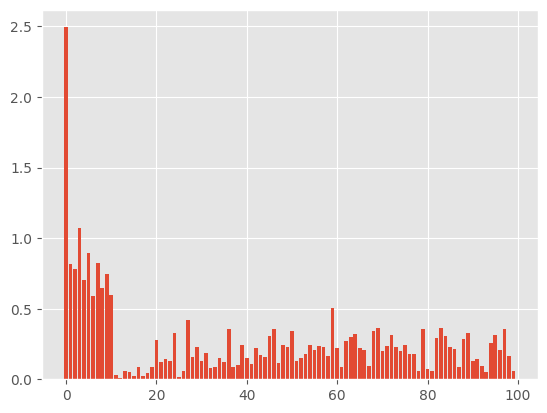

In [267]:
k = 100
plt.bar(np.arange(k), height=np.mean(np.abs(igs_bg_bnn[:,:k]), axis=0))

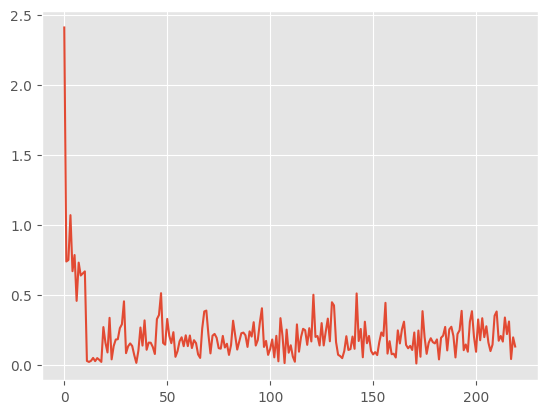

In [278]:
plt.plot(np.mean(np.abs(igs_bg_bnn), axis=0))

### Wine data

In [285]:
wine_df = pd.read_csv(f"{data_dir}/winequality-red.csv", delimiter=";")
print(wine_df.shape)
wine_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [311]:
from sklearn.preprocessing import QuantileTransformer
seed = 739


In [353]:
J_zeros = np.zeros((X_train.shape[-1], X_train.shape[-1]))
lr_0, disc_lr_0 = 1e-3, 0.5
temp = 1.0
epochs, num_cycles = 500, 10
eta, mu = 1.0, 10.0
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds[:5]

rmse_scores = []

for seed in tqdm(curr_seeds):
    transformer = QuantileTransformer(random_state=seed, output_distribution='normal')
    X_wine_df, y_wine_df = wine_df.iloc[:,:-1], wine_df.iloc[:,-1]
    X_train_outer, X_train, X_val, X_test, \
    y_train_outer, y_train, y_val, y_test, (train_indices, val_indices) = preprocess_data(seed, X_wine_df, y_wine_df, transformer, val_size=0.2, test_size=0.2)

    outer_data_loader_v2 = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=256, shuffle=True)
    bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader_v2, epochs, num_cycles,
                                                                                  0.25, 2, lr_0, disc_lr_0, [50], temp, 1.0,
                                                                                  eta, mu, J_zeros, "relu", show_pgbar=False)



    # print(len(bg_bnn_states))
    bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states, bg_bnn_disc_states)
    # print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")
    rmse_scores.append(bnn_bg_rmse_test)

np.mean(rmse_scores)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.44s/it]


0.64703685

In [351]:
rmse_scores

[Array(0.67332584, dtype=float32),
 Array(0.58484507, dtype=float32),
 Array(0.65108687, dtype=float32),
 Array(0.6574644, dtype=float32),
 Array(0.6684622, dtype=float32)]

In [ ]:
hp_configs = {"epochs": 200, "num_cycles": 20, "batch_size": 256, "act_fn": "swish",
              "beta": 0.25, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [100],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

save_dir = f"{data_dir}/exp_data_5/synthetic/wine/"

VERSION = "1"


print(len(curr_seeds))
cross_val_runs(curr_seeds, X_wine_df, y_wine_df, J_zeros, VERSION, save_dir, saved_config=False, **hp_configs)